In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris 
from tqdm import tqdm
from scipy.sparse import csr_matrix
from lib.gradient_tools import BasicGradientUpdater
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics.pairwise import linear_kernel
from lib.sparse_tools import sparse_clip, sparse_pos_clip, dense_pos_clip, sparse_sparse_dot, dense_sparse_add, \
                             dense_sparse_mul, sparse_sub_with_clip

In [2]:
with open("bernstein_km.dump", "rb") as fin:
    km = pickle.load(fin)

n = km.shape[0]

In [3]:
iris_data = load_iris()

In [4]:
km = csr_matrix(linear_kernel(iris_data["data"]))
n = km.shape[0]
y = iris_data["target"]
y[y > 0] = 1

-----

## SkLearn

In [5]:
%%time
y = [0] * 50 + [1]*100
clf = SVC(kernel="precomputed", probability=True)
clf.fit(km.toarray(), y)
print(classification_report(y, clf.predict(km.toarray())))
print(roc_auc_score(y, clf.predict_proba(km.toarray())[:, 1]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00       100

avg / total       1.00      1.00      1.00       150

1.0
CPU times: user 9.22 ms, sys: 4.24 ms, total: 13.5 ms
Wall time: 25.7 ms


In [6]:
clf.support_

array([23, 41, 98], dtype=int32)

## Ours

In [58]:
# Input:
# km: csr_matrix
# y: np.array

C = 1.0
γ = 5000. # O(n)
L1 = 2*γ
ε = 1e-3
n_iter = 500


# inv2nC = 1. / (2 * n * C)
# invL1 = 1. / L1
# fracCL1 = C / L1

y = np.array([+1.] * 50 + [-1.] * 100)

# γy = γ * y

In [59]:
def grad_f(x):
    t = x.copy()
    t.data -= 1 / (2 * n * C)
    return (-csr_matrix([1] * n).T + km.multiply(y.reshape(1, -1) * y.reshape(-1, 1)).dot(x.T) + \
           γ*sparse_clip(-x.T, 0, None) + γ*sparse_clip(t.T, 0, None)).T

In [60]:
%%time

# Initialize gradient heap

ν = csr_matrix(([0., 0.], [1, 2], [0, 2]), shape=(1, n))

# grad1 = dense_sparse_add(-y, 2 * (km[0] - km[1]))

# yν_ = dense_sparse_mul(y, ν)
# yν1 = sparse_pos_clip(-yν_)
# yν2 = sparse_sub_with_clip(yν_, inv2nC)
# grad2 = dense_sparse_mul(γy, yν1 + yν2)

# grad = dense_sparse_add(grad1, grad2)
# min_heap = BasicGradientUpdater(grad)
# max_heap = BasicGradientUpdater(-grad)

# Iterate until stopping criteria is met

norms = []
h_vals = []

for t in range(n_iter):
    if min_heap.get_norm() <= ε:
        break
    ν_prev = ν.copy()
    
    # math
    current_grad = dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν)))
    norms.append(sparse.linalg.norm(current_grad))
    
    # anikin
    min_ix = current_grad.argmin()#min_heap.get_coordinate()
    max_ix = current_grad.argmax()#max_heap.get_coordinate()
    min_val = current_grad.min()
    max_val = current_grad.max()
    h_val = fracCL1 * (max_val - min_val)
    h_vec = csr_matrix(([-h_val, +h_val], [min_ix, max_ix], [0, 2]), shape=(1, n))
    h_vec.sort_indices()
    h_vals.append(h_val)
    #print(t, h_val, min_ix, max_ix)
    
    # Yura
    ν +=  h_vec
    assert np.abs(ν.sum()) <= 1e-6
    assert (min_heap.get() == -max_heap.get()).all()

    # Gradient update
#     νinvL1h = ν_prev + invL1 * h_vec
#     δ1 = (2 * h_val / L1) * (km[min_ix] - km[max_ix])
#     δ21 =  sparse_pos_clip(dense_sparse_mul(-y, νinvL1h))
#     δ22 = -sparse_pos_clip(dense_sparse_mul(-y, ν_prev))
#     δ23 =  sparse_sub_with_clip(dense_sparse_mul(y, νinvL1h), inv2nC)
#     δ24 = -sparse_sub_with_clip(dense_sparse_mul(y, ν_prev), inv2nC)
#     δ2 = dense_sparse_mul(γy, δ21 + δ22 + δ23 + δ24)
#     δ = δ1 + δ2
    #δ = np.asarray(dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))) - min_heap.get())[0]
    #min_heap.update(δ)
    #max_heap.update(-δ)

λ = dense_sparse_mul(y, ν)

CPU times: user 2.77 s, sys: 44.8 ms, total: 2.81 s
Wall time: 2.87 s


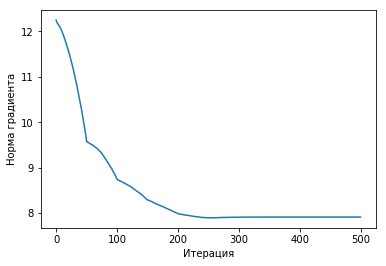

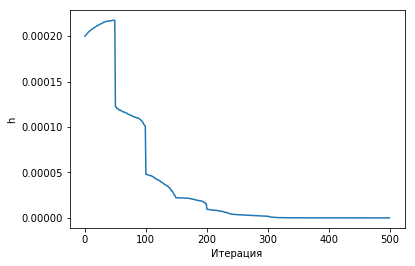

In [61]:
plt.xlabel("Итерация")
plt.ylabel("Норма градиента")
plt.plot(norms)
plt.show()
plt.xlabel("Итерация")
plt.ylabel("h")
plt.plot(h_vals)
plt.show()

In [57]:
dense_sparse_mul(y, grad_f(dense_sparse_mul(y, ν))).data

array([ 0.64611892,  0.64612185,  0.64612267,  0.64611831,  0.64611888,
        0.64611884,  0.64612214,  0.64612071,  0.64612414,  0.64612064,
        0.64612032,  0.64611813,  0.64611949,  0.64611951,  0.64612185,
        0.64611977,  0.64611962,  0.64612208,  0.64612076,  0.64612214,
        0.64612219,  0.64612235,  0.64611895,  0.64612324,  0.64611993,
        0.64611907,  0.64612315,  0.64612186,  0.64611915,  0.64612206,
        0.64612469,  0.64612219,  0.646123  ,  0.64612205,  0.64611814,
        0.64612319,  0.64612325,  0.64612018,  0.64612087,  0.646122  ,
        0.64612099,  0.64612235,  0.64611984,  0.646122  ,  0.64611828,
        0.64612206,  0.64611854,  0.64611935,  0.64611825,  0.64612032,
        0.64612337,  0.64612017,  0.64612556,  0.64611839,  0.64612018,
        0.64611768,  0.64612204,  0.64612405,  0.6461201 ,  0.64612073,
        0.64612183,  0.64611894,  0.64612108,  0.6461186 ,  0.64611817,
        0.64612006,  0.64611874,  0.64612315,  0.64612469,  0.64

---